In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d carlosrunner/pizza-not-pizza

 80% 80.0M/101M [00:00<00:00, 152MB/s]
100% 101M/101M [00:00<00:00, 148MB/s] 


In [ ]:
import zipfile
ref=zipfile.ZipFile("/content/pizza-not-pizza.zip")
ref.extractall()

In [ ]:
import os
image_dir="/content/pizza_not_pizza"

In [ ]:
not_pizza = [(os.path.join(image_dir,"not_pizza",image),0) for image in os.listdir(os.path.join(image_dir,"not_pizza")) if image.split(".")[1] == "jpg"]
pizza = [(os.path.join(image_dir,"pizza",image),1) for image in os.listdir(os.path.join(image_dir,"pizza")) if image.split(".")[1] == "jpg"]

In [ ]:
import pandas as pd
df = pd.DataFrame(not_pizza+pizza,columns=['filename','category'])
df.head()

,filename,category
0,/content/pizza_not_pizza/not_pizza/98656.jpg,0
1,/content/pizza_not_pizza/not_pizza/1112272.jpg,0
2,/content/pizza_not_pizza/not_pizza/593982.jpg,0
3,/content/pizza_not_pizza/not_pizza/2291292.jpg,0
4,/content/pizza_not_pizza/not_pizza/2289899.jpg,0


In [ ]:
df["category"].value_counts()

0    983
1    983
Name: category, dtype: int64

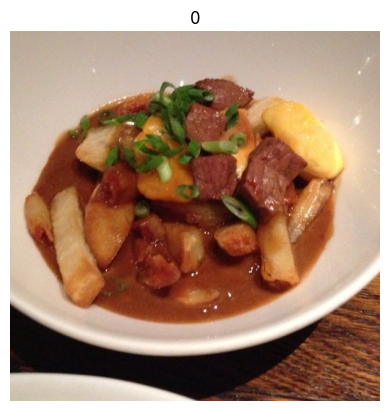

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = df['filename'].iloc[0]
image_label = df['category'].iloc[0]

img = Image.open(image_path)
plt.imshow(img)
plt.title(image_label)
plt.axis('off')
plt.show()

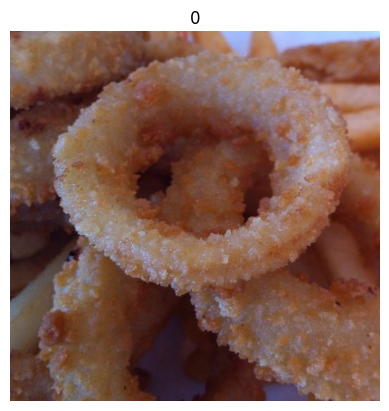

In [ ]:
image_path = df['filename'].iloc[200]
image_label = df['category'].iloc[200]

img = Image.open(image_path)
plt.imshow(img)
plt.title(image_label)
plt.axis('off')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train_df,next_df=train_test_split(df,test_size=0.4,random_state=42,shuffle=True)
val_df,test_df=train_test_split(df,test_size=0.2,random_state=42,shuffle=True)

In [ ]:
train_df.category = train_df.category.astype(str)
val_df.category = val_df.category.astype(str)
test_df.category = test_df.category.astype(str)

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_dataframe(train_df,x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)
val_generator = datagen.flow_from_dataframe(val_df,x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)
test_generator = datagen.flow_from_dataframe(test_df,x_col='filename',y_col='category',target_size=(256,256),batch_size=32,class_mode="binary",shuffle=True)

Found 1179 validated image filenames belonging to 2 classes.
Found 1572 validated image filenames belonging to 2 classes.
Found 394 validated image filenames belonging to 2 classes.


In [ ]:
model=Sequential()
model.add(Conv2D(16,(3,3),padding="valid",activation="relu",input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),strides=2,padding="valid"))

model.add(Conv2D(32,(3,3),padding="valid",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),strides=2,padding="valid"))

model.add(Conv2D(64,(3,3),padding="valid",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),strides=2,padding="valid"))

model.add(Conv2D(128,(3,3),padding="valid",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),strides=2,padding="valid"))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 32)      128       
 chNormalization)                                                
                                                        

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

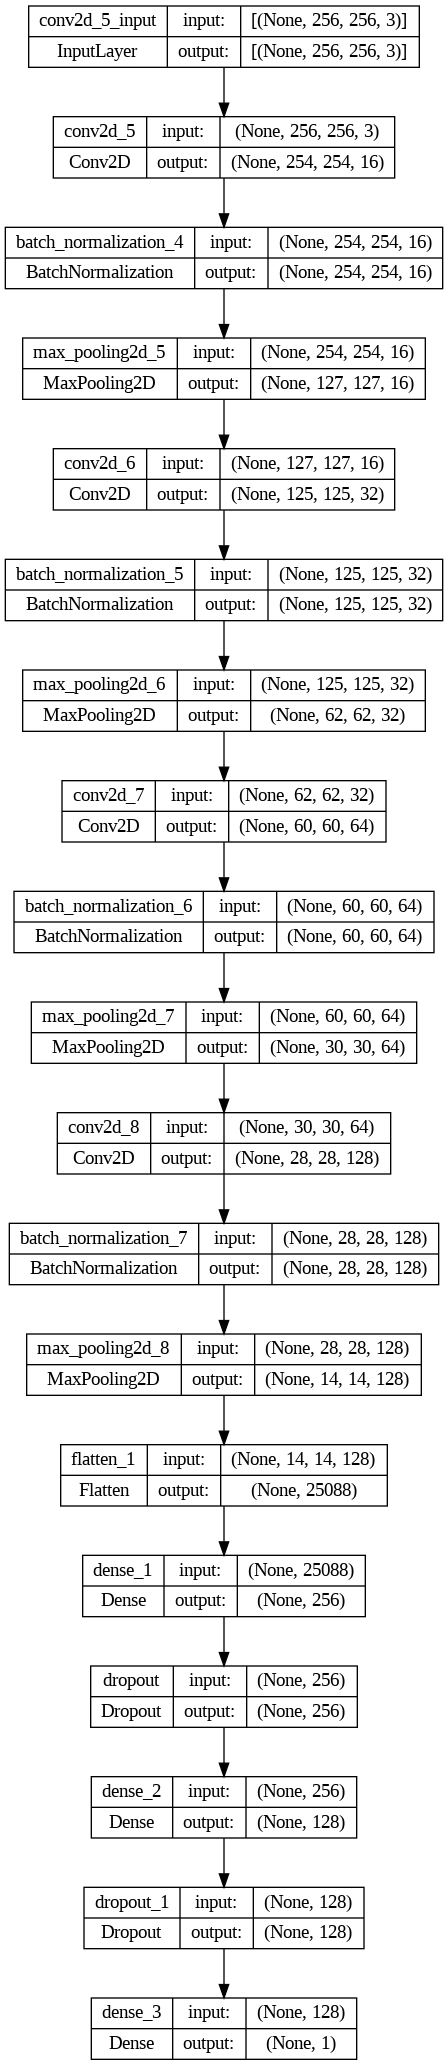

In [ ]:
from keras.utils import plot_model
plot_model(model,show_layer_names=True,show_shapes=True)

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 5.9 MB/s eta 0:00:00


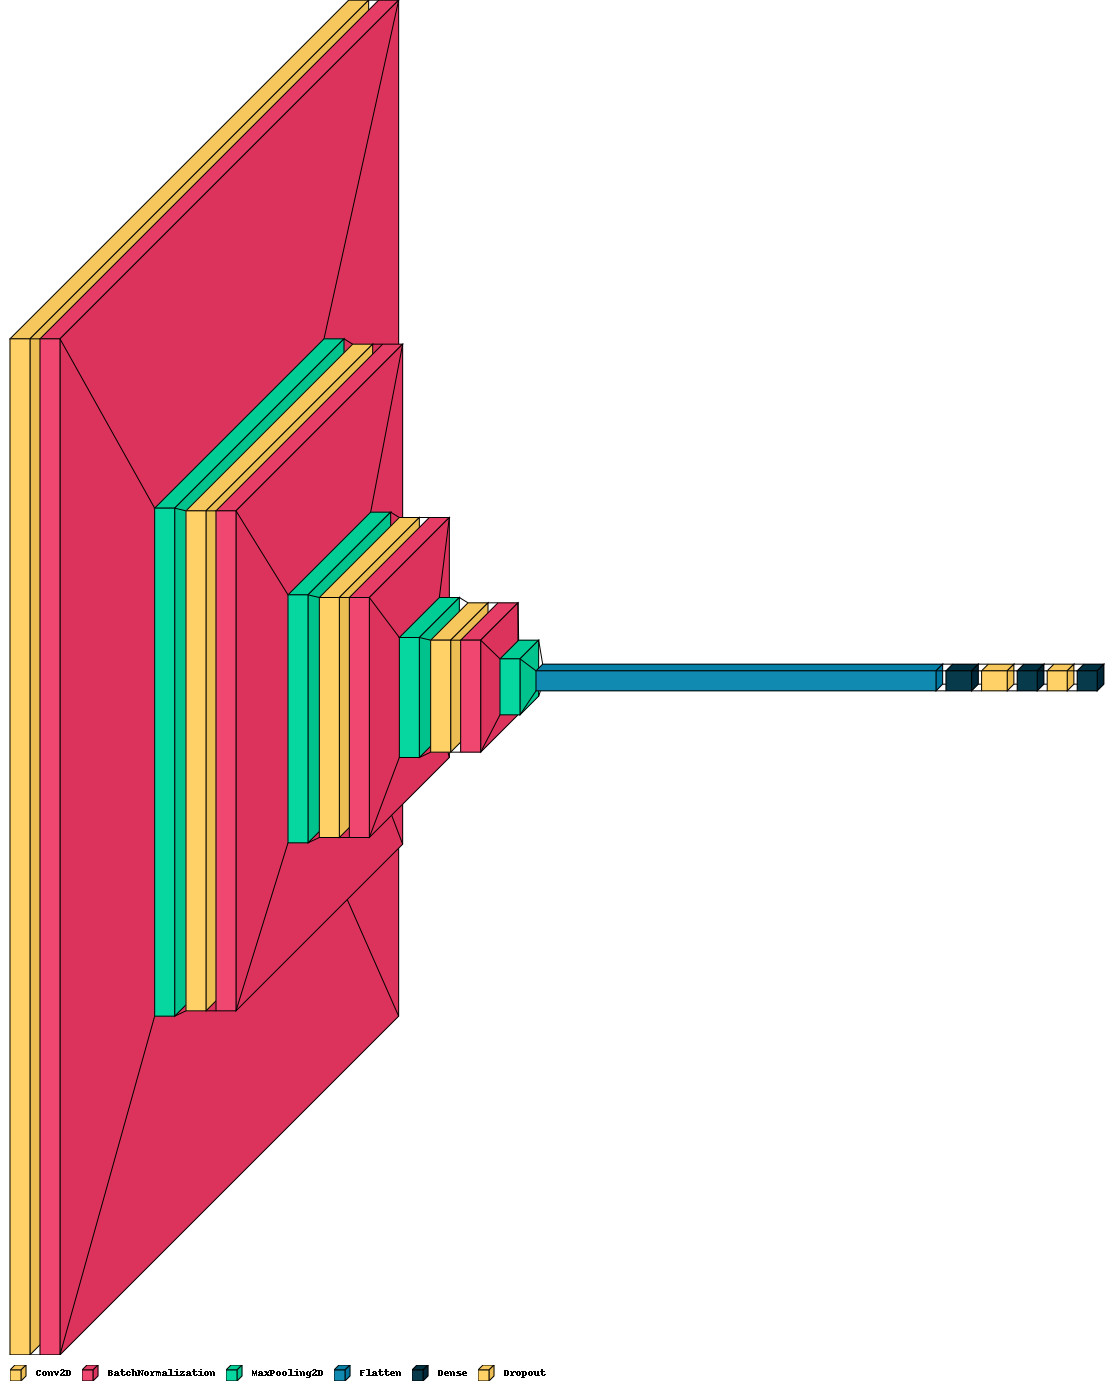

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [ ]:
history =model.fit(train_generator, epochs=15, validation_data=val_generator)

Epoch 1/15
37/37 [==============================] - 108s 3s/step - loss: 1.8560 - accuracy: 0.6641 - val_loss: 0.7095 - val_accuracy: 0.5299
Epoch 2/15
37/37 [==============================] - 110s 3s/step - loss: 1.2765 - accuracy: 0.6853 - val_loss: 0.8416 - val_accuracy: 0.5204
Epoch 3/15
37/37 [==============================] - 110s 3s/step - loss: 1.0535 - accuracy: 0.6735 - val_loss: 0.8190 - val_accuracy: 0.5293
Epoch 4/15
37/37 [==============================] - 107s 3s/step - loss: 0.7616 - accuracy: 0.7193 - val_loss: 0.7364 - val_accuracy: 0.5668
Epoch 5/15
37/37 [==============================] - 105s 3s/step - loss: 0.6332 - accuracy: 0.7523 - val_loss: 0.7757 - val_accuracy: 0.5821
Epoch 6/15
37/37 [==============================] - 103s 3s/step - loss: 0.5224 - accuracy: 0.7761 - val_loss: 1.0440 - val_accuracy: 0.5999
Epoch 7/15
37/37 [==============================] - 103s 3s/step - loss: 0.5070 - accuracy: 0.7981 - val_loss: 1.8129 - val_accuracy: 0.4994
Epoch 8/15
37

<function matplotlib.pyplot.show(close=None, block=None)>

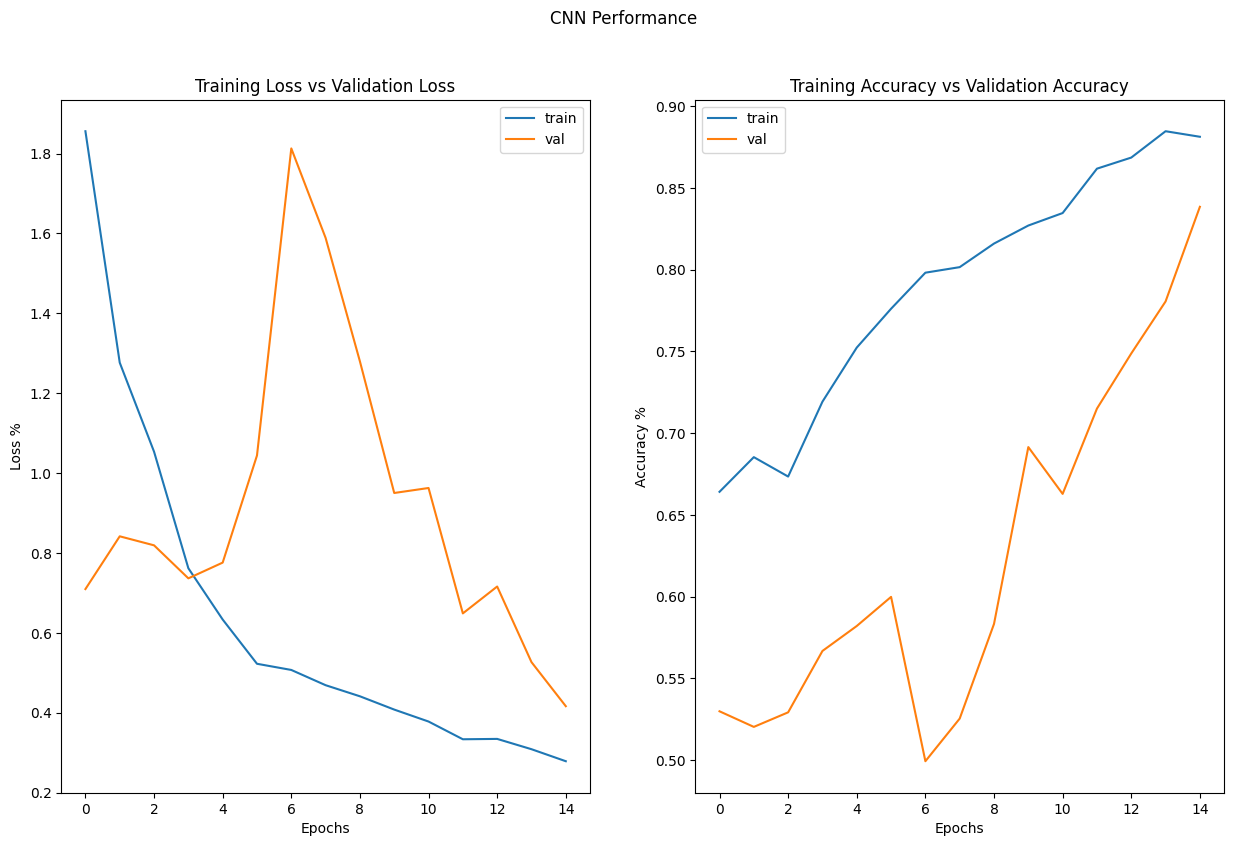

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,9))
total_epochs = [i for i in range(len(history.history['loss']))]
fig.suptitle("CNN Performance")

ax[0].plot(total_epochs,history.history['loss'],label='train')
ax[0].plot(total_epochs,history.history['val_loss'],label='val')
ax[0].set_title("Training Loss vs Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss %")
ax[0].legend(loc='best')

ax[1].plot(total_epochs,history.history['accuracy'],label='train')
ax[1].plot(total_epochs,history.history['val_accuracy'],label='val')
ax[1].set_title("Training Accuracy vs Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy %")
ax[1].legend(loc='best')

plt.show

In [ ]:
evaluation_result = model.evaluate(test_generator)

print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

13/13 [==============================] - 10s 722ms/step - loss: 0.8018 - accuracy: 0.7234
Loss: 0.8017537593841553
Accuracy: 0.7233502268791199


<ipython-input-29-32175ba081f5>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


1/1 [==============================] - 0s 36ms/step


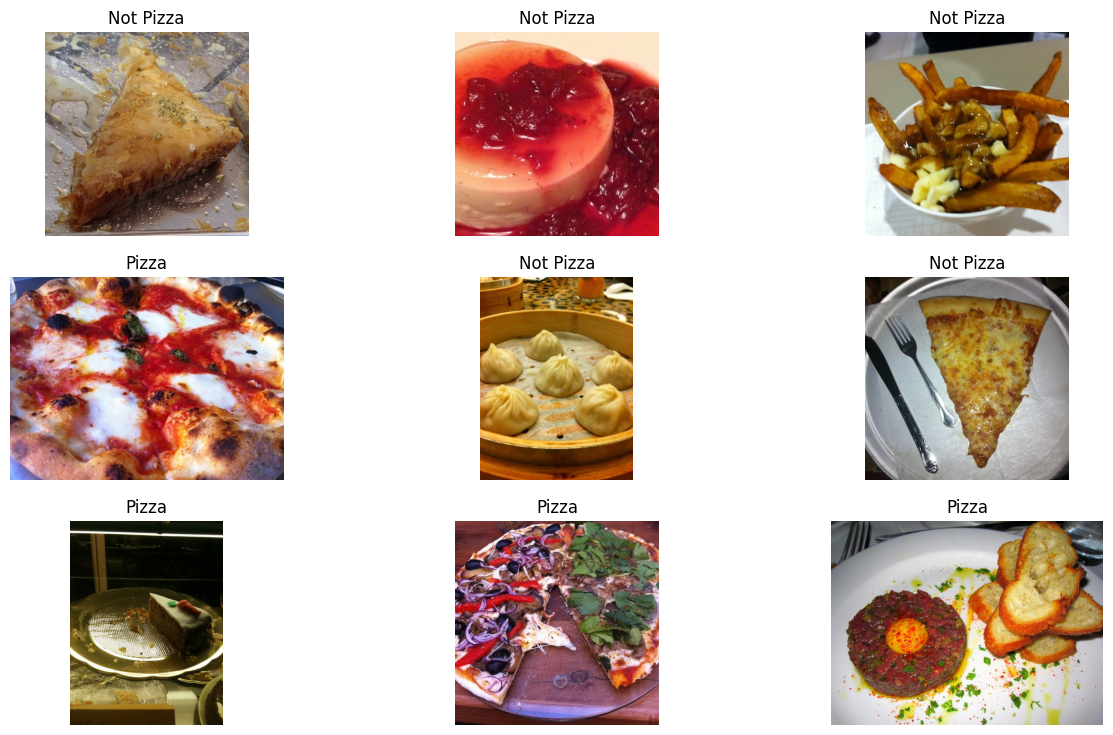

In [ ]:
import cv2
import numpy as np
sample_images = test_df.sample(n=9)
class_names = os.listdir(image_dir)[:2]
figure,ax = plt.subplots(figsize=(15,9))
for i,image in enumerate(sample_images.filename):
    plt.subplot(3,3,i+1)
    img = cv2.imread(image)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.axis('off')
    img = cv2.resize(img,(256,256))
    img = np.expand_dims(img,axis=0)
    img = img.astype('float32')
    img = datagen.standardize(img)
    y_pred=model.predict(img)
    if y_pred>0.5:
        plt.title('Pizza')
    else:
        plt.title("Not Pizza")
plt.show()

VGG

In [ ]:
from keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.optimizers import Adam
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Freeze the layers of the pre-trained VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')